In [2]:
import fastf1
from fastf1.core import Session
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

fastf1.Cache.enable_cache('../data')
fastf1.Cache.offline_mode(True)

# Load the qualifying session
qualifying_session = fastf1.get_session(2023, 'Bahrain', 'Q')
qualifying_session.load()

# Load the race session
race_session = fastf1.get_session(2023, 'Bahrain', 'R')
race_session.load()

core           INFO 	Loading data for Bahrain Grand Prix - Qualifying [v3.4.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '55', '14', '63', '44', '18', '31', '27', '4', '77', '24', '22', '23', '2', '20', '81', '21', '10']
core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.4.3]
req            INFO 	Using cached d

In [3]:
def get_weather_data(session: Session, type: str):
    weather_data = session.laps.get_weather_data()
    weather = weather_data[['AirTemp', 'Humidity', 'TrackTemp']].mean()
    weather = weather.rename({
        'AirTemp': f'{type}_AirTemp',
        'Humidity': f'{type}_Humidity',
        'TrackTemp': f'{type}_TrackTemp'
    })
    return weather

def process_qualifying(session: Session):
    # Get qualifying results
    qualifying_results = session.results

    # Select and rename qualifying features
    qualifying_features = qualifying_results[['DriverNumber', 'Position']].copy()
    qualifying_features.rename(columns={'Position': 'Position_Qualifying'}, inplace=True)

    # Check for 'Q1', 'Q2', 'Q3' columns and add if missing
    for q_col in ['Q1', 'Q2', 'Q3']:
        if q_col in qualifying_results.columns:
            qualifying_features[q_col] = qualifying_results[q_col]
        else:
            qualifying_features[q_col] = pd.NaT

    # Convert lap times to total seconds
    for col in ['Q1', 'Q2', 'Q3']:
        qualifying_features[col] = qualifying_features[col].apply(
            lambda x: x.total_seconds() if isinstance(x, pd.Timedelta) else (x if isinstance(x, (float, int)) else 999)
        )

    # Get average lap times for each driver in qualifying
    qualifying_laps = session.laps
    qualifying_laps = qualifying_laps[pd.notnull(qualifying_laps['LapTime'])]

    if not qualifying_laps.empty:
        qualifying_laps = qualifying_laps.copy()
        qualifying_laps['LapTime_seconds'] = qualifying_laps['LapTime'].dt.total_seconds()
        qualifying_avg_lap_times = qualifying_laps.groupby('DriverNumber')['LapTime_seconds'].mean().reset_index()
        qualifying_avg_lap_times.rename(columns={'LapTime_seconds': 'Qualifying_AvgLapTime'}, inplace=True)
    else:
        qualifying_avg_lap_times = pd.DataFrame(columns=['DriverNumber', 'Qualifying_AvgLapTime'])

    # Merge qualifying features with average lap times
    qualifying_features['DriverNumber'] = qualifying_features['DriverNumber'].astype(str)
    qualifying_avg_lap_times['DriverNumber'] = qualifying_avg_lap_times['DriverNumber'].astype(str)
    qualifying_features = pd.merge(qualifying_features, qualifying_avg_lap_times, on='DriverNumber', how='left')

    return qualifying_features

# Process qualifying data
qualifying_features = process_qualifying(qualifying_session)
qualifying_weather = get_weather_data(qualifying_session, 'Qualifying')


In [4]:
def get_telemetry_data_up_to_lap(session: Session, lap_number: int):
    """
    Retrieve aggregated telemetry data up to a specific lap for all drivers.

    Parameters:
    - session (Session): The race session object.
    - lap_number (int): The current lap number to simulate real-time prediction.

    Returns:
    - pandas.DataFrame: Aggregated telemetry data for all drivers up to the specified lap.
    """
    telemetry_data_list = []
    for driver in session.drivers:
        try:
            # Get all laps for the driver up to the current lap
            driver_laps = session.laps.pick_driver(driver).pick_accurate().pick_not_deleted()
            driver_laps = driver_laps[driver_laps['LapNumber'] <= lap_number]

            if driver_laps.empty:
                raise Exception("No valid laps up to this lap number.")

            # Aggregate telemetry data
            telemetry = driver_laps.get_car_data()
            pos_data = driver_laps.get_pos_data()
            avg_speed = telemetry['Speed'].mean()
            max_speed = telemetry['Speed'].max()
            avg_throttle = telemetry['Throttle'].mean()
            avg_brake = telemetry['Brake'].mean()
            avg_rpm = telemetry['RPM'].mean()
            avg_gear = telemetry['nGear'].mean()
            max_rpm = telemetry['RPM'].max()
            on_track_percentage = pos_data['Status'].value_counts(normalize=True).get('OnTrack', 0) * 100

            telemetry_data_list.append({
                'DriverNumber': driver,
                'AvgSpeed': avg_speed,
                'MaxSpeed': max_speed,
                'AvgThrottle': avg_throttle,
                'AvgBrake': avg_brake,
                'AvgRPM': avg_rpm,
                'MaxRPM': max_rpm,
                'AvgGear': avg_gear,
                'OnTrack%': on_track_percentage
            })

        except Exception as e:
            print(f"Telemetry data not available for driver {driver} up to lap {lap_number}: {e}")
            # Handle missing data by setting NaNs
            telemetry_data_list.append({
                'DriverNumber': driver,
                'AvgSpeed': np.nan,
                'MaxSpeed': np.nan,
                'AvgThrottle': np.nan,
                'AvgBrake': np.nan,
                'AvgRPM': np.nan,
                'MaxRPM': np.nan,
                'AvgGear': np.nan,
                'OnTrack%': np.nan
            })

    # Convert list to DataFrame
    telemetry_data = pd.DataFrame(telemetry_data_list)
    telemetry_data['DriverNumber'] = telemetry_data['DriverNumber'].astype(str)
    return telemetry_data


In [5]:
def process_race_up_to_lap(session: Session, lap_number: int):
    """
    Process race features up to a specific lap.

    Parameters:
    - session (Session): The race session object.
    - lap_number (int): The current lap number to simulate real-time prediction.

    Returns:
    - pandas.DataFrame: Race features for all drivers up to the specified lap.
    """
    race_results = session.results[['DriverNumber', 'Abbreviation', 'TeamName', 'GridPosition']].copy()
    race_results.rename(columns={
        'Abbreviation': 'Abbreviation_Race',
        'TeamName': 'TeamName_Race',
        'GridPosition': 'GridPosition_Race'
    }, inplace=True)

    # Get laps up to the current lap
    race_laps = session.laps.pick_accurate().pick_not_deleted()
    race_laps = race_laps[race_laps['LapNumber'] <= lap_number]

    if not race_laps.empty:
        race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
        race_avg_lap_times = race_laps.groupby('DriverNumber')['LapTime_seconds'].mean().reset_index()
        race_avg_lap_times.rename(columns={'LapTime_seconds': 'Race_AvgLapTime'}, inplace=True)
    else:
        race_avg_lap_times = pd.DataFrame(columns=['DriverNumber', 'Race_AvgLapTime'])

    # Merge race features with average lap times
    race_results['DriverNumber'] = race_results['DriverNumber'].astype(str)
    race_avg_lap_times['DriverNumber'] = race_avg_lap_times['DriverNumber'].astype(str)
    race_features = pd.merge(race_results, race_avg_lap_times, on='DriverNumber', how='left')

    # Merge telemetry data
    race_telemetry_data = get_telemetry_data_up_to_lap(session, lap_number)
    race_features = pd.merge(race_features, race_telemetry_data, on='DriverNumber', how='left')

    return race_features


In [6]:
def get_weather_data_up_to_lap(session: Session, lap_number: int, type: str):
    """
    Retrieve weather data up to a specific lap in the race session.

    Parameters:
    - session (Session): The race session object.
    - lap_number (int): The current lap number to simulate real-time prediction.
    - type (str): Type of weather data ('Race' or 'Qualifying').

    Returns:
    - pandas.Series: Averaged weather data up to the specified lap.
    """
    weather_data = session.laps.get_weather_data()

    # Get the session time at the end of the current lap
    current_lap_times = session.laps[session.laps['LapNumber'] == lap_number]
    if current_lap_times.empty:
        max_session_time = session.laps['LapStartTime'].max()
    else:
        max_session_time = current_lap_times['LapStartTime'].max()

    # Select weather data up to max_session_time using the correct 'Time' column
    weather_data = weather_data[weather_data['Time'] <= max_session_time]

    # Compute the mean weather conditions up to the current lap
    weather = weather_data[['AirTemp', 'Humidity', 'TrackTemp']].mean()
    weather = weather.rename({
        'AirTemp': f'{type}_AirTemp',
        'Humidity': f'{type}_Humidity',
        'TrackTemp': f'{type}_TrackTemp'
    })
    return weather


In [7]:
from keras.src.saving import load_model
import joblib

# Load the models
model = load_model('race_outcome_model_1.keras')
model_v2 = load_model('race_outcome_model_1_v2.keras')

# Load the preprocessor
preprocessor = joblib.load('preprocessor.joblib')


In [8]:
# Get the event name
event_name = race_session.event['EventName']

# Prepare storage for predictions
lap_predictions = []

# Number of laps in the race
max_lap_number = int(race_session.laps['LapNumber'].max())

MIN_LAPS_FOR_PREDICTION = 5

for lap_number in range(1, max_lap_number + 1):
    if lap_number < MIN_LAPS_FOR_PREDICTION:
        print(f"Lap {lap_number}: Insufficient data for prediction.")
        continue
    print(f"Processing lap {lap_number}/{max_lap_number}")

    # Process race data up to the current lap
    race_features = process_race_up_to_lap(race_session, lap_number)

    # Retrieve race weather data up to the current lap
    race_weather = get_weather_data_up_to_lap(race_session, lap_number, 'Race')

    # Merge qualifying and race features
    combined_results = pd.merge(
        qualifying_features,
        race_features,
        on='DriverNumber',
        how='inner'
    )

    # Add qualifying weather data
    for col in qualifying_weather.index:
        combined_results[col] = qualifying_weather[col]

    # Add race weather data
    for col in race_weather.index:
        combined_results[col] = race_weather[col]

    # Add EventName
    combined_results['EventName'] = event_name

    # Ensure numerical columns are of correct type
    numerical_cols = [
        'Position_Qualifying', 'GridPosition_Race', 'Q1', 'Q2', 'Q3',
        'Qualifying_AvgLapTime', 'Race_AvgLapTime',
        'AvgSpeed', 'MaxSpeed', 'AvgThrottle', 'AvgBrake',
        'AvgRPM', 'MaxRPM', 'AvgGear',
        'Qualifying_AirTemp', 'Qualifying_Humidity', 'Qualifying_TrackTemp',
        'Race_AirTemp', 'Race_Humidity', 'Race_TrackTemp'
    ]

    # Only process existing columns
    existing_cols = [col for col in numerical_cols if col in combined_results.columns]

    for col in existing_cols:
        combined_results[col] = pd.to_numeric(combined_results[col], errors='coerce')

    # Fill NaN values in existing numerical columns
    combined_results[existing_cols] = combined_results[existing_cols].fillna(0)

    # Prepare the list of columns to select (matching training features)
    feature_cols = [
        'DriverNumber',
        'Abbreviation_Race',
        'TeamName_Race',
        'Position_Qualifying',
        'GridPosition_Race',
        'Q1',
        'Q2',
        'Q3',
        'Qualifying_AvgLapTime',
        'Race_AvgLapTime',
        'AvgSpeed',
        'MaxSpeed',
        'AvgThrottle',
        'AvgBrake',
        'AvgRPM',
        'MaxRPM',
        'AvgGear',
        'OnTrack%',
        'Qualifying_AirTemp',
        'Qualifying_Humidity',
        'Qualifying_TrackTemp',
        'Race_AirTemp',
        'Race_Humidity',
        'Race_TrackTemp',
        'EventName'
    ]

    # Only select existing columns
    existing_feature_cols = [col for col in feature_cols if col in combined_results.columns]

    # Select features
    features = combined_results[existing_feature_cols].fillna(0)

    # Process features with preprocessor (excluding 'DriverNumber' and 'Abbreviation_Race')
    X_processed = preprocessor.transform(features.drop(columns=['DriverNumber', 'Abbreviation_Race']))

    # Make predictions with models
    y_pred = model.predict(X_processed).flatten()
    y_pred_v2 = model_v2.predict(X_processed).flatten()

    # Store predictions along with driver info
    lap_prediction = combined_results[['DriverNumber', 'Abbreviation_Race']].copy()
    lap_prediction['LapNumber'] = lap_number
    lap_prediction['PredictedRacePosition_Model1'] = y_pred
    lap_prediction['PredictedRacePosition_Model2'] = y_pred_v2
    lap_predictions.append(lap_prediction)

# Concatenate all lap predictions
all_lap_predictions = pd.concat(lap_predictions, ignore_index=True)


Lap 1: Insufficient data for prediction.
Lap 2: Insufficient data for prediction.
Lap 3: Insufficient data for prediction.
Lap 4: Insufficient data for prediction.
Processing lap 5/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Processing lap 6/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processing lap 7/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processing lap 8/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Processing lap 9/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processing lap 10/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processing lap 11/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processing lap 12/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processing lap 13/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Processing lap 14/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Processing lap 15/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processing lap 16/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processing lap 17/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processing lap 18/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processing lap 19/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processing lap 20/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Processing lap 21/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processing lap 22/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Processing lap 23/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Processing lap 24/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processing lap 25/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processing lap 26/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Processing lap 27/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processing lap 28/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Processing lap 29/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Processing lap 30/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Processing lap 31/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Processing lap 32/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Processing lap 33/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Processing lap 34/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Processing lap 35/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Processing lap 36/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Processing lap 37/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Processing lap 38/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Processing lap 39/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Processing lap 40/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processing lap 41/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processing lap 42/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Processing lap 43/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Processing lap 44/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processing lap 45/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processing lap 46/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processing lap 47/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Processing lap 48/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processing lap 49/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Processing lap 50/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processing lap 51/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Processing lap 52/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processing lap 53/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Processing lap 54/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Processing lap 55/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processing lap 56/57


/var/folders/3r/y8q1_zkx3l333fyh9s34n0180000gn/T/ipykernel_70101/2651518594.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_laps['LapTime_seconds'] = race_laps['LapTime'].dt.total_seconds()
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Dev

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Processing lap 57/57


/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"
/Users/karrtopelka/Developer/lnu/f1-v1/venv/lib/python3.12/site-packages/fastf1/core.py:3022: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instea

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [9]:
# Get actual positions for each driver at each lap
lap_positions = []
for lap_number in range(1, max_lap_number + 1):
    lap_data = race_session.laps[race_session.laps['LapNumber'] == lap_number]
    lap_data = lap_data[['DriverNumber', 'Position']].copy()
    lap_data['LapNumber'] = lap_number
    lap_positions.append(lap_data)
lap_positions = pd.concat(lap_positions, ignore_index=True)
lap_positions.rename(columns={'Position': 'ActualRacePosition'}, inplace=True)

# Merge actual positions with predictions
all_lap_predictions = pd.merge(
    all_lap_predictions,
    lap_positions,
    on=['DriverNumber', 'LapNumber'],
    how='left'
)


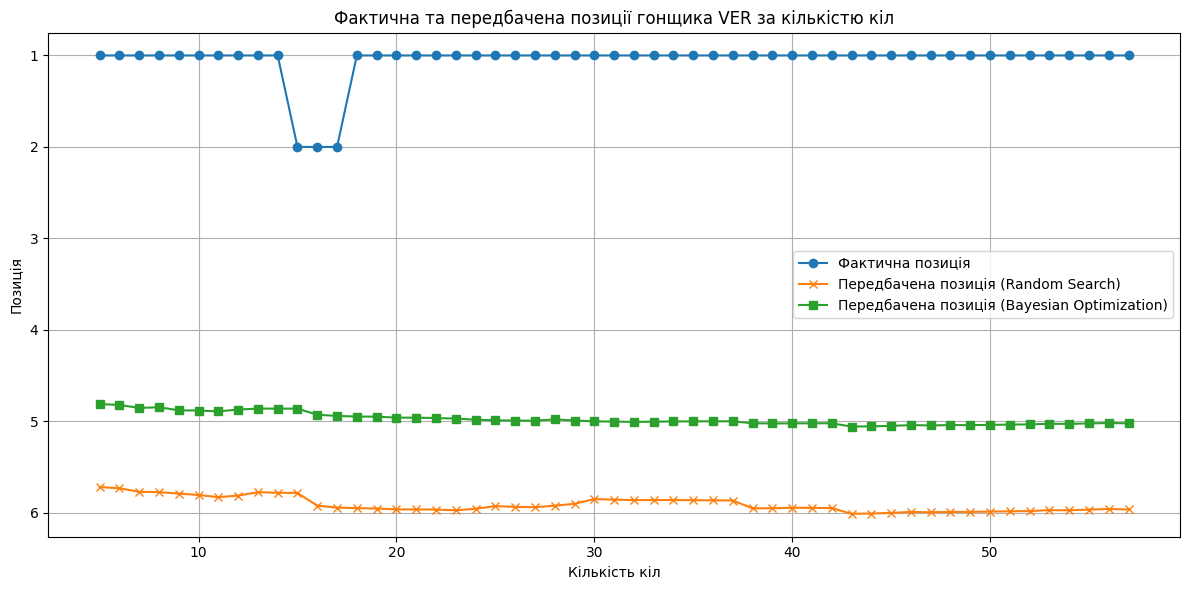

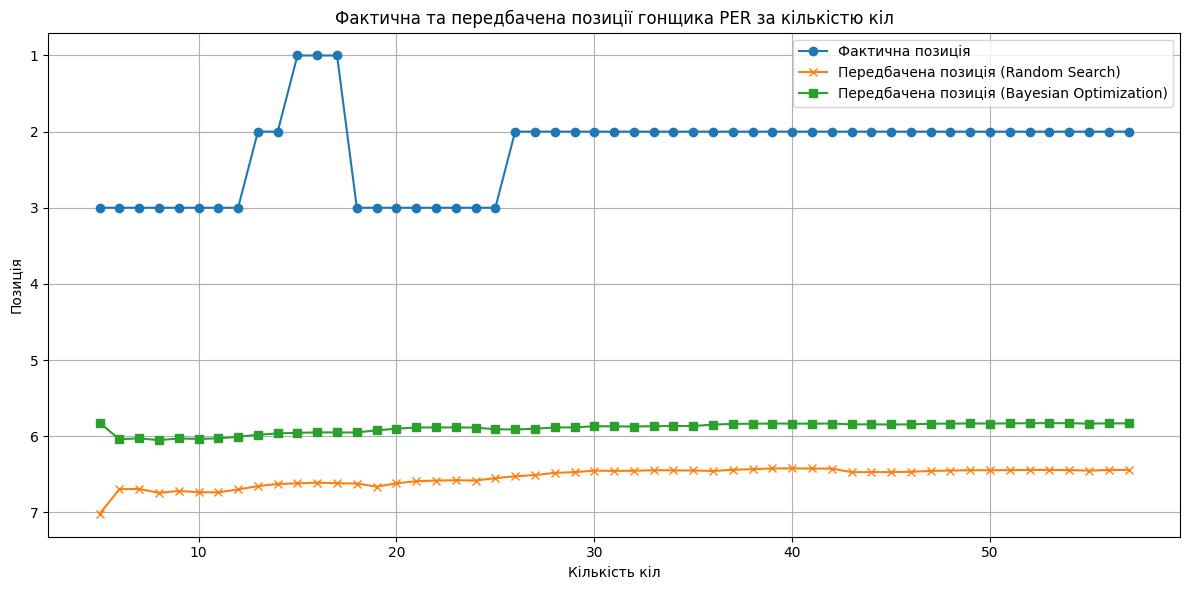

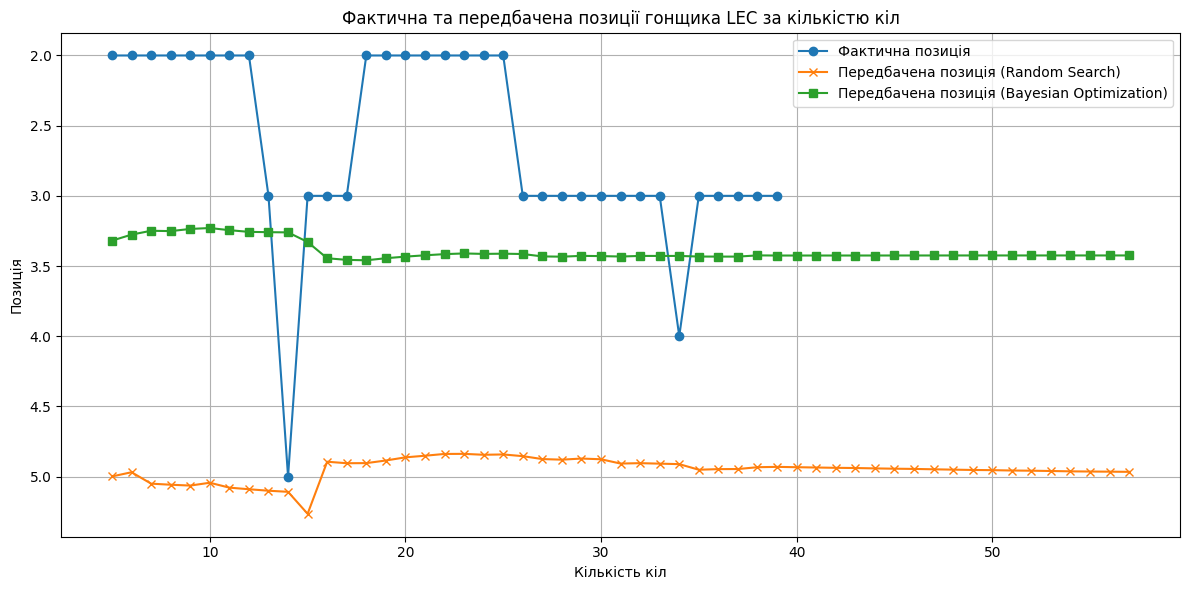

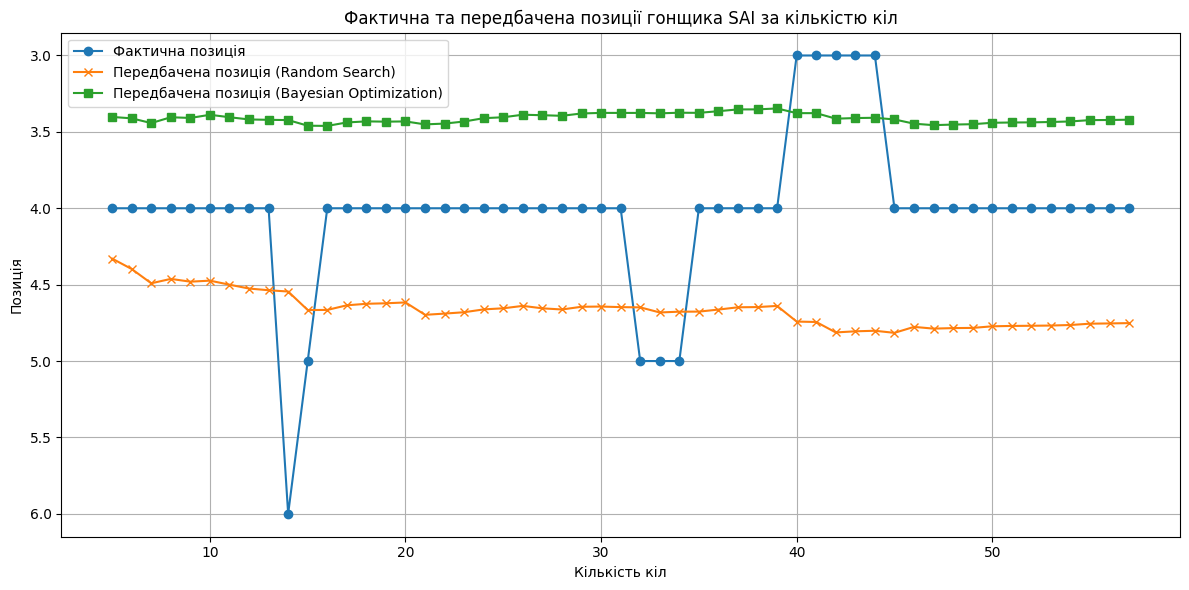

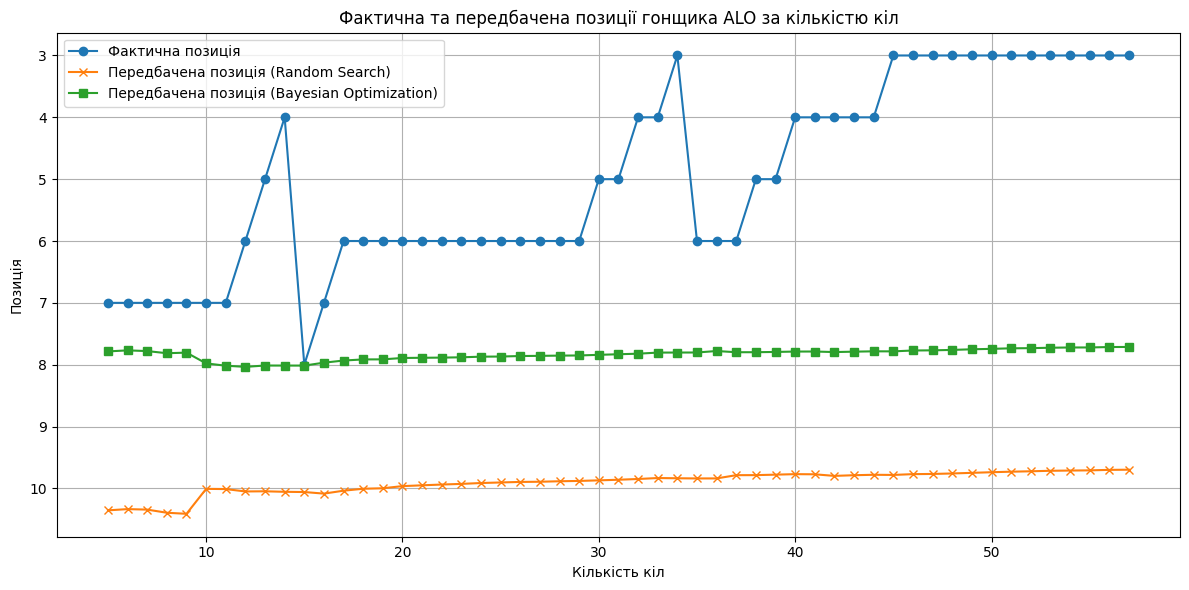

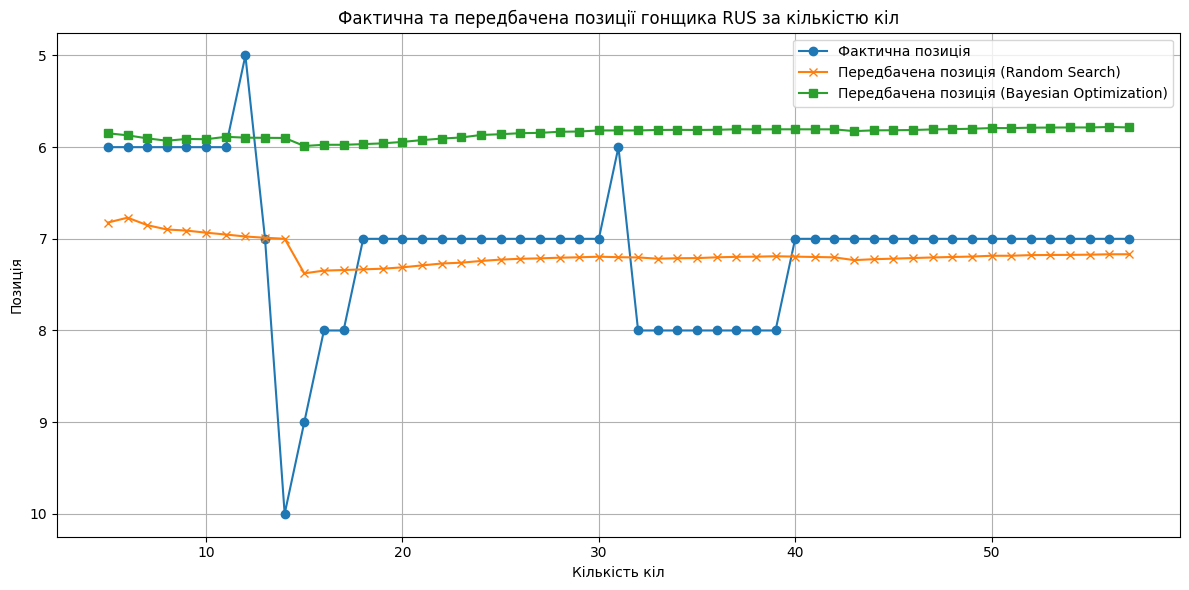

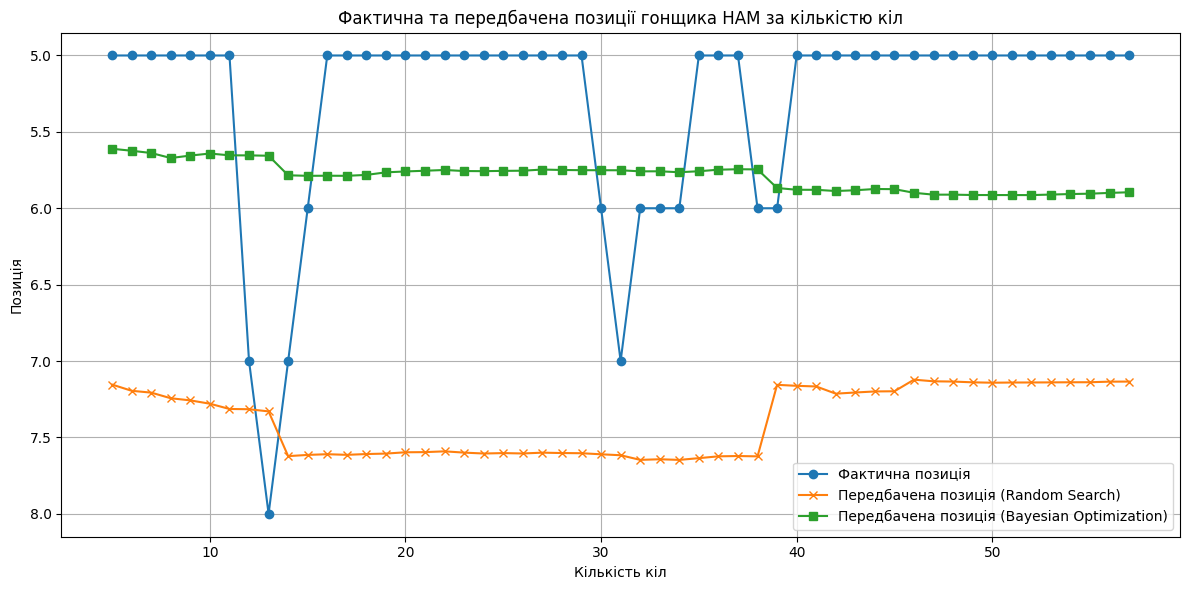

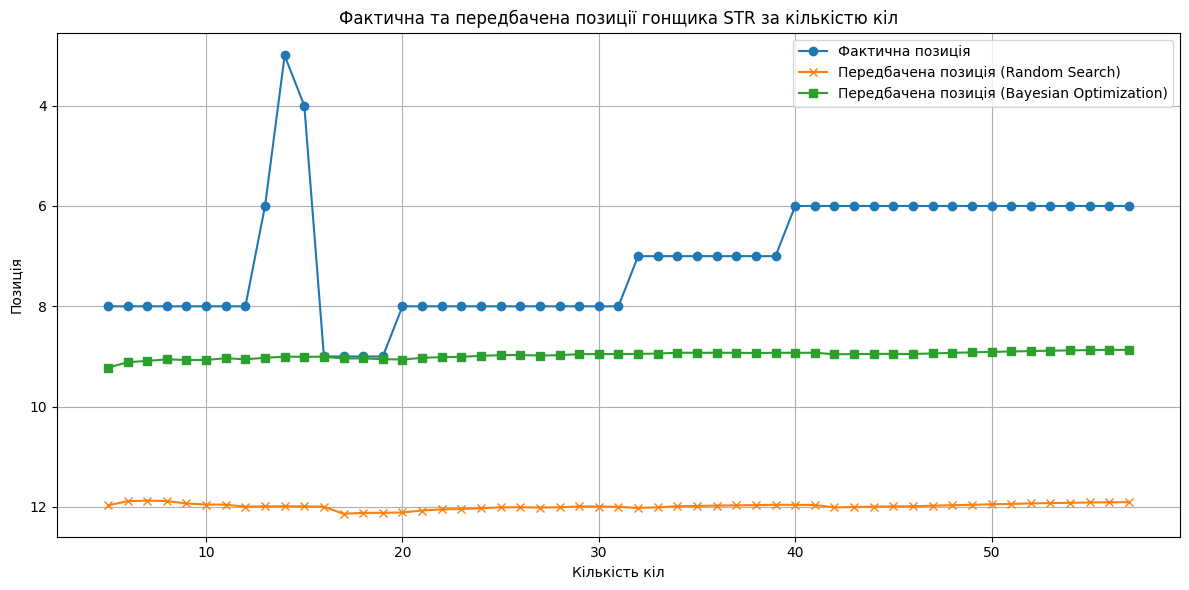

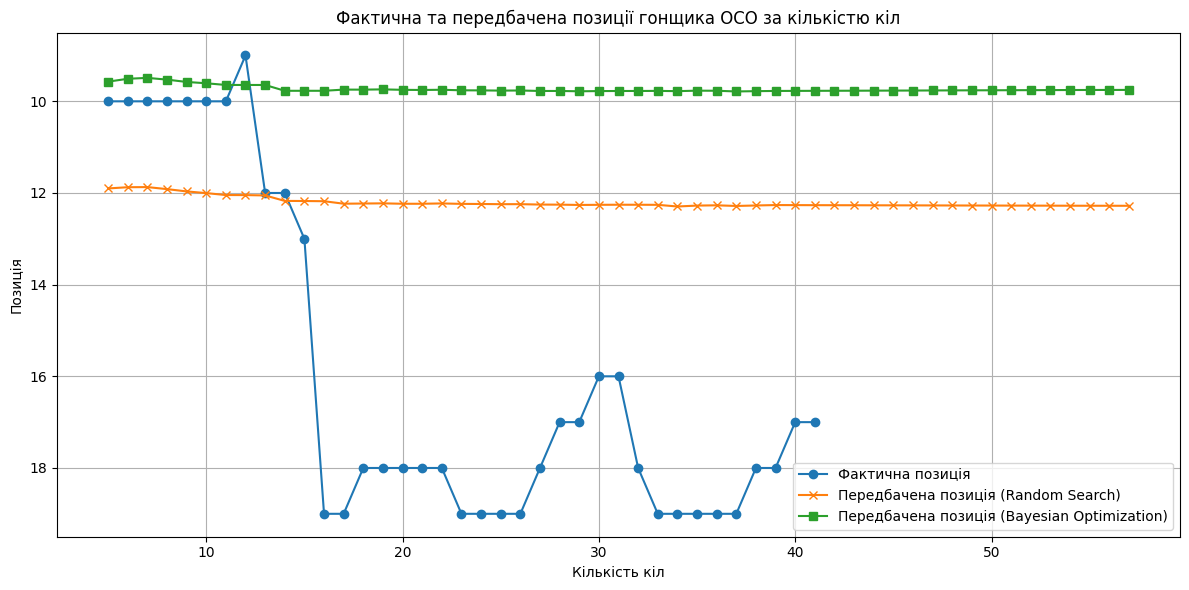

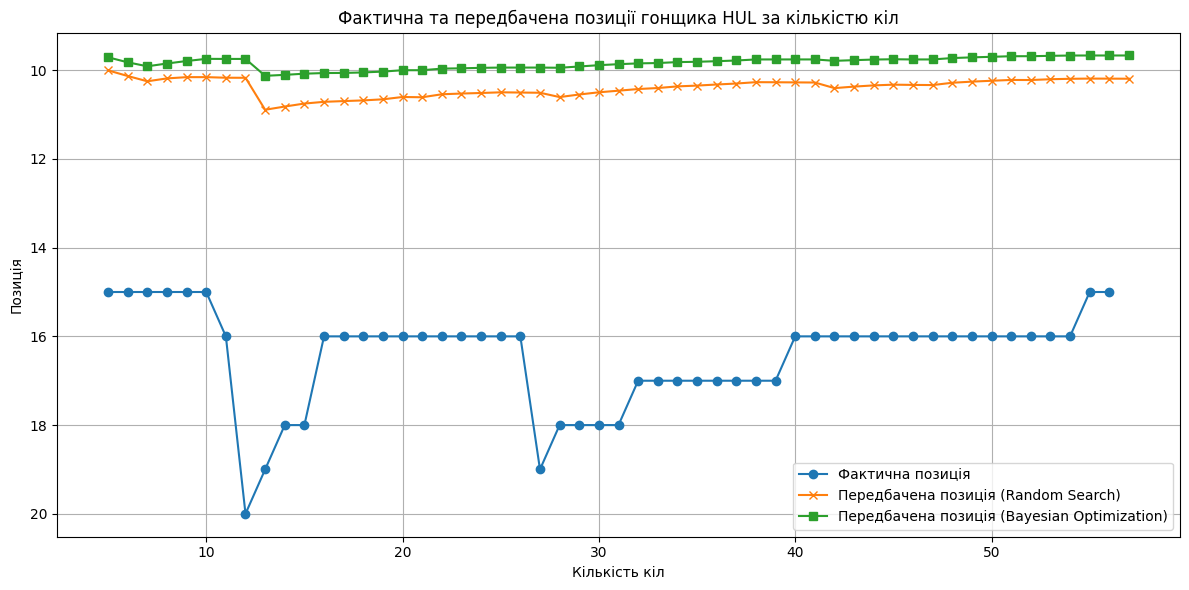

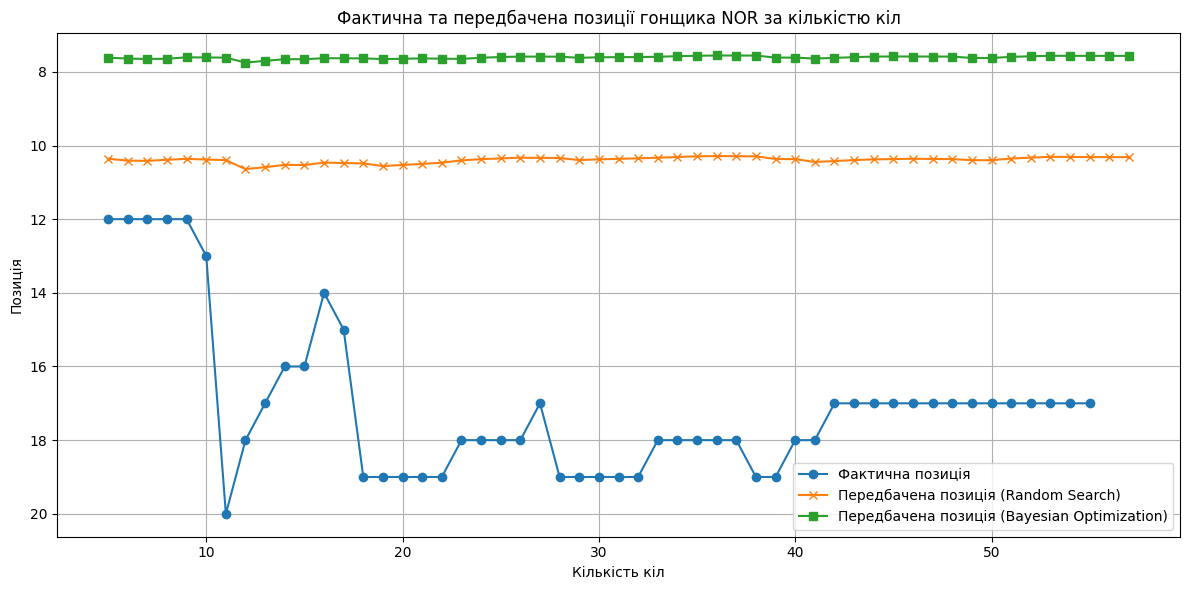

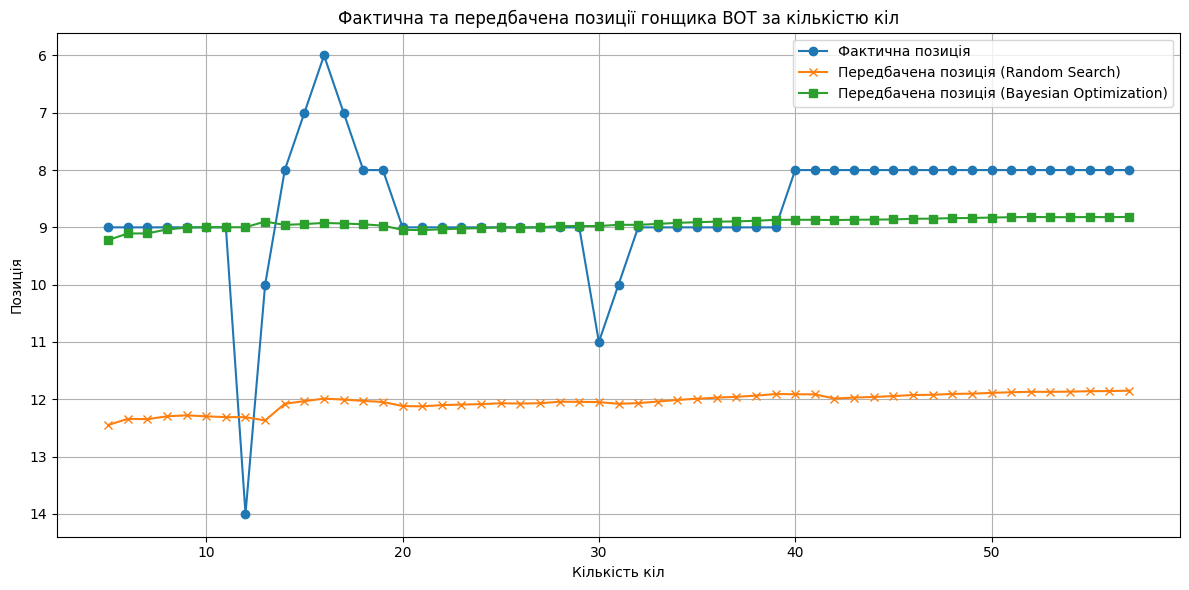

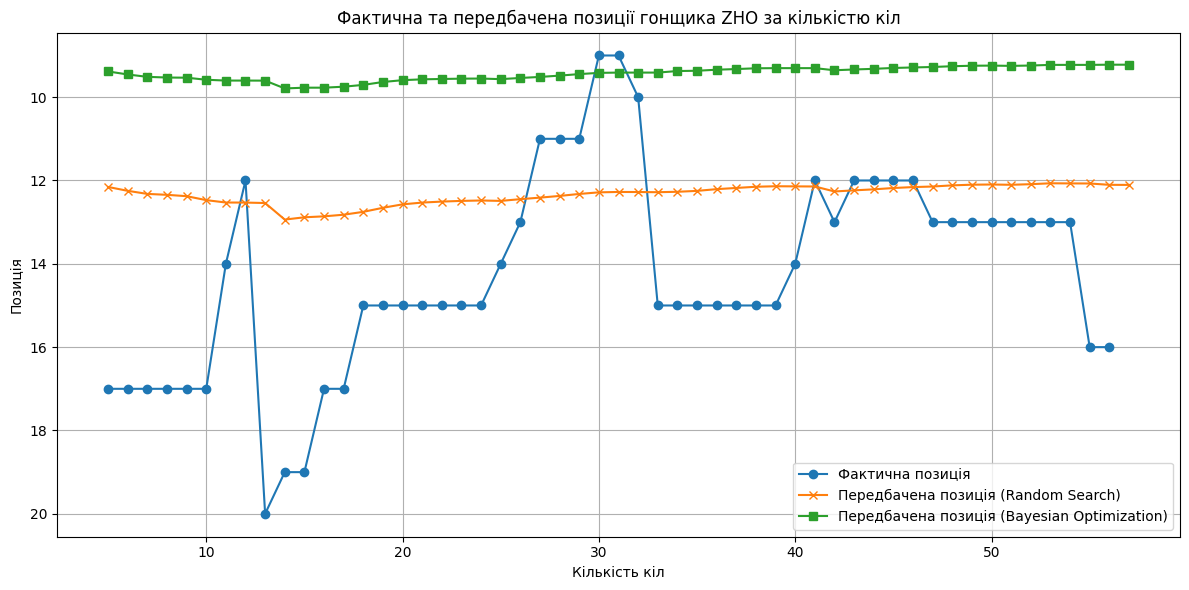

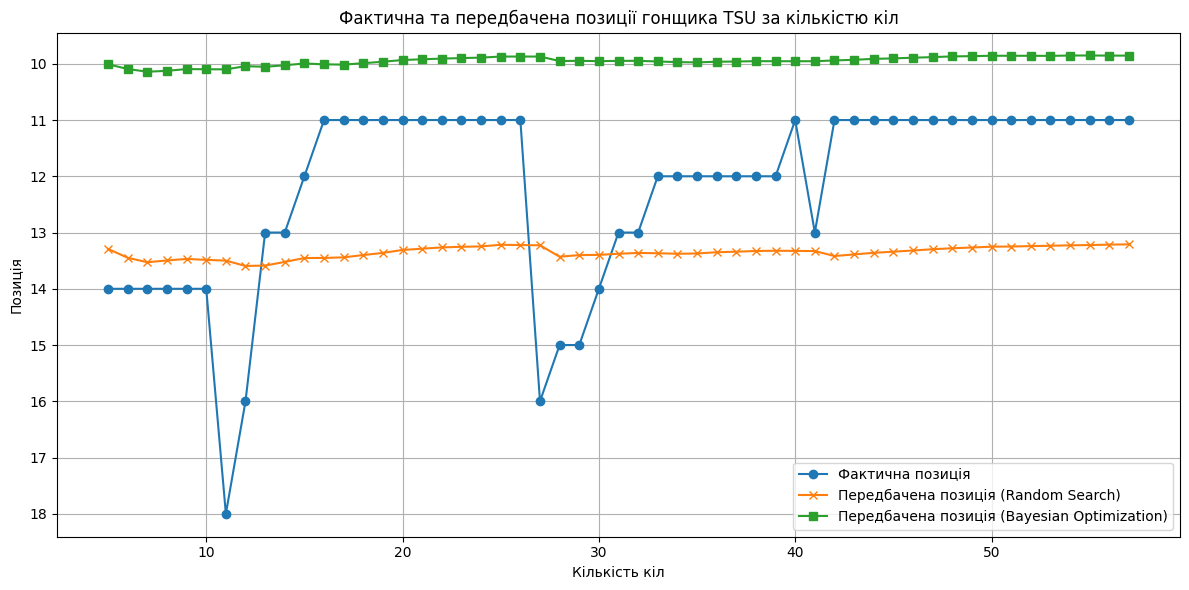

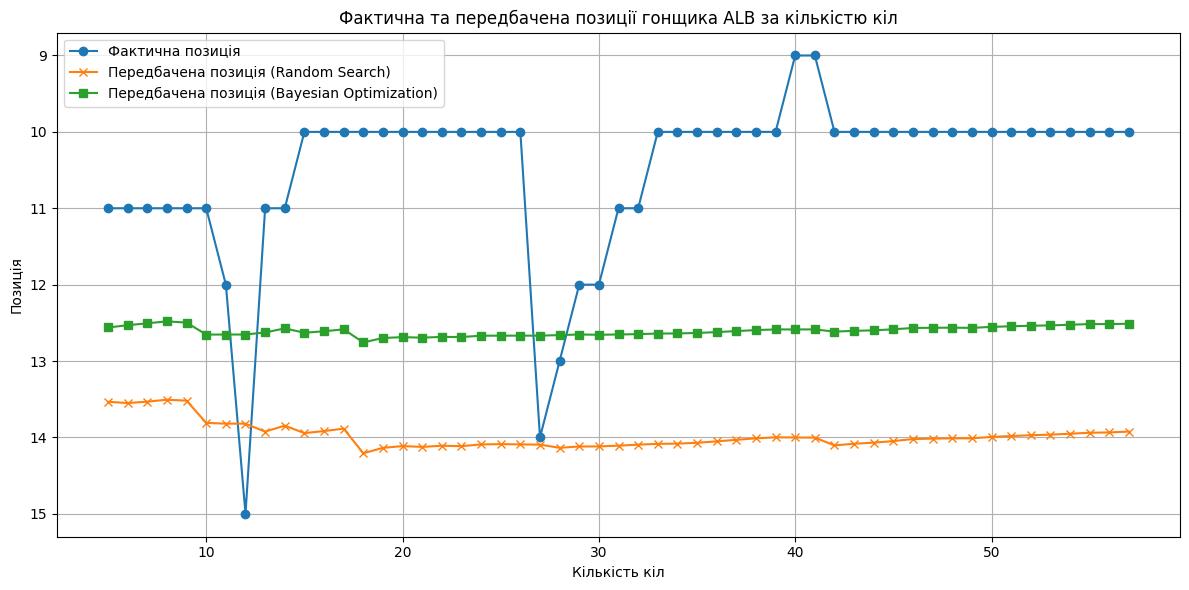

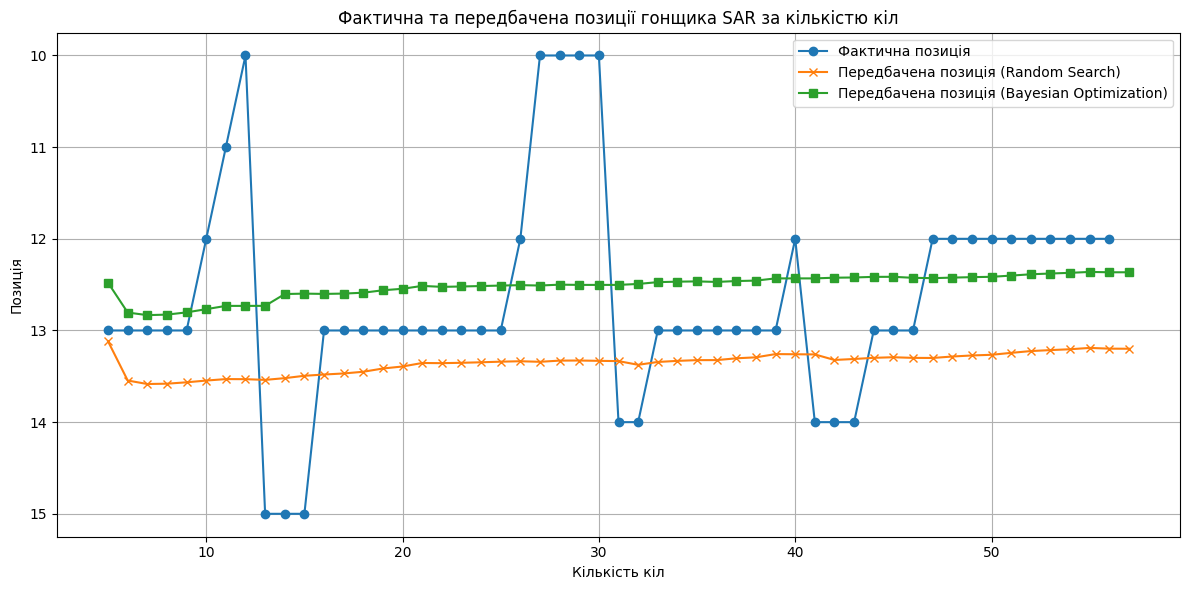

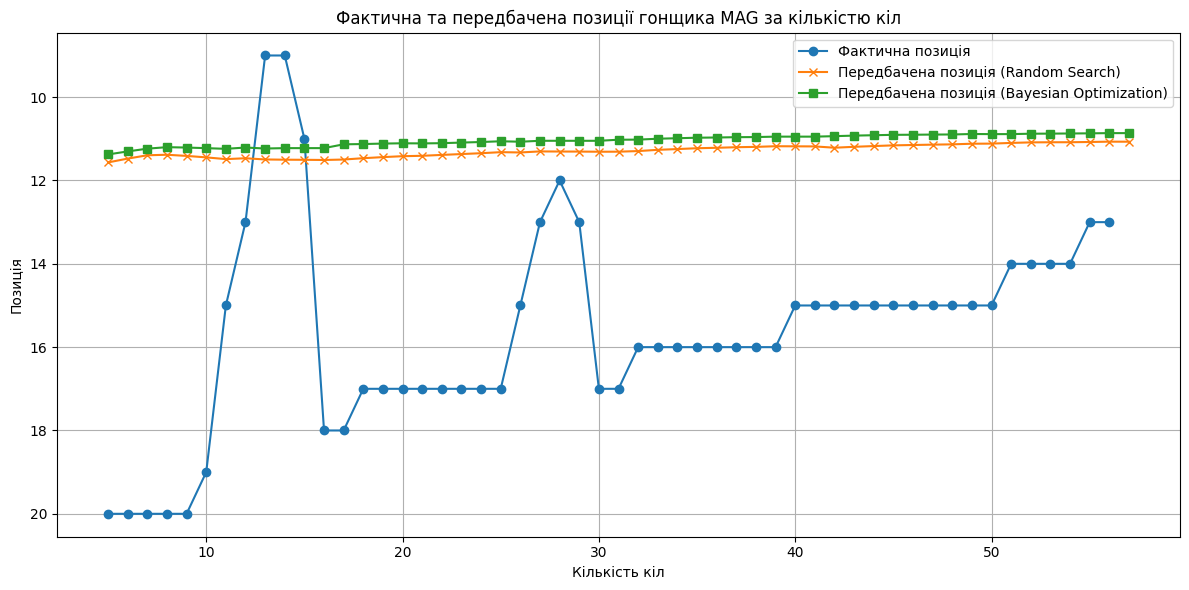

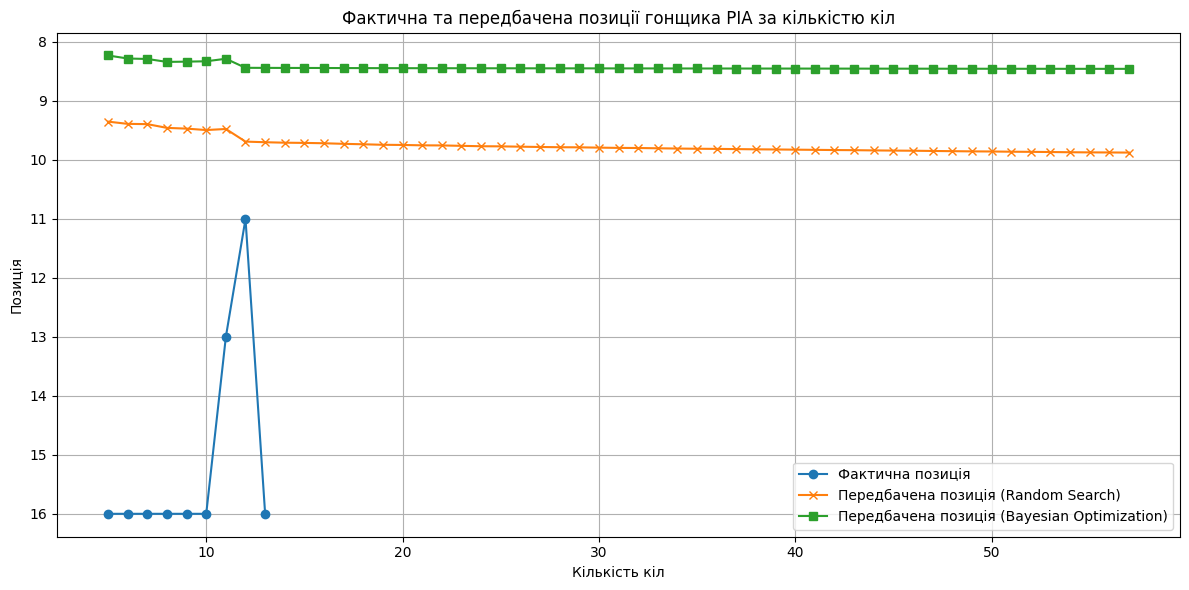

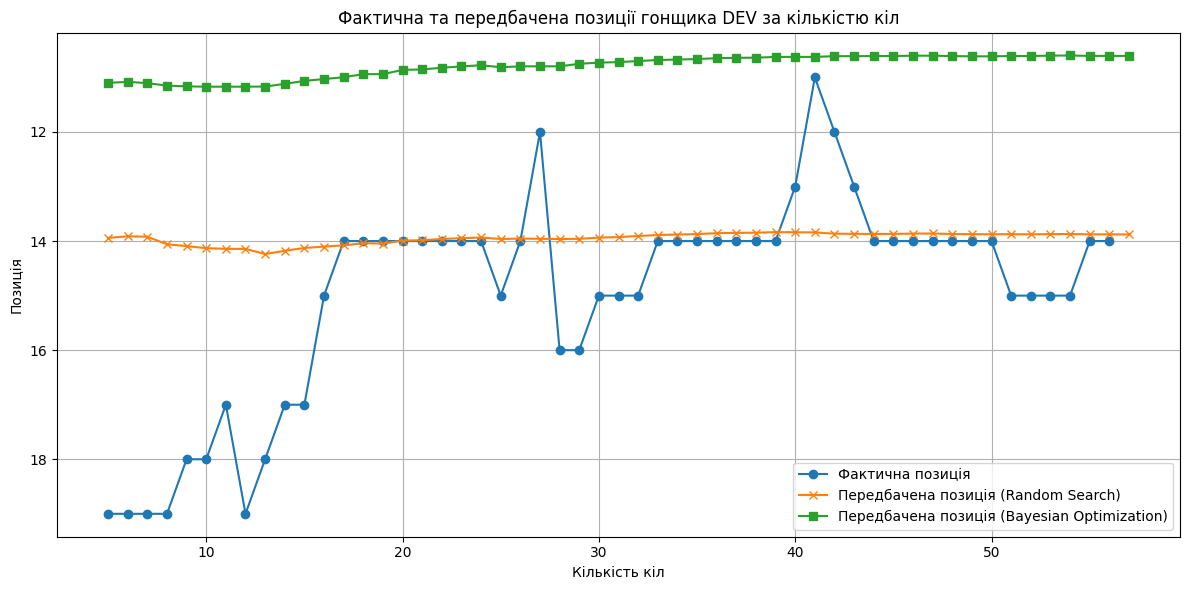

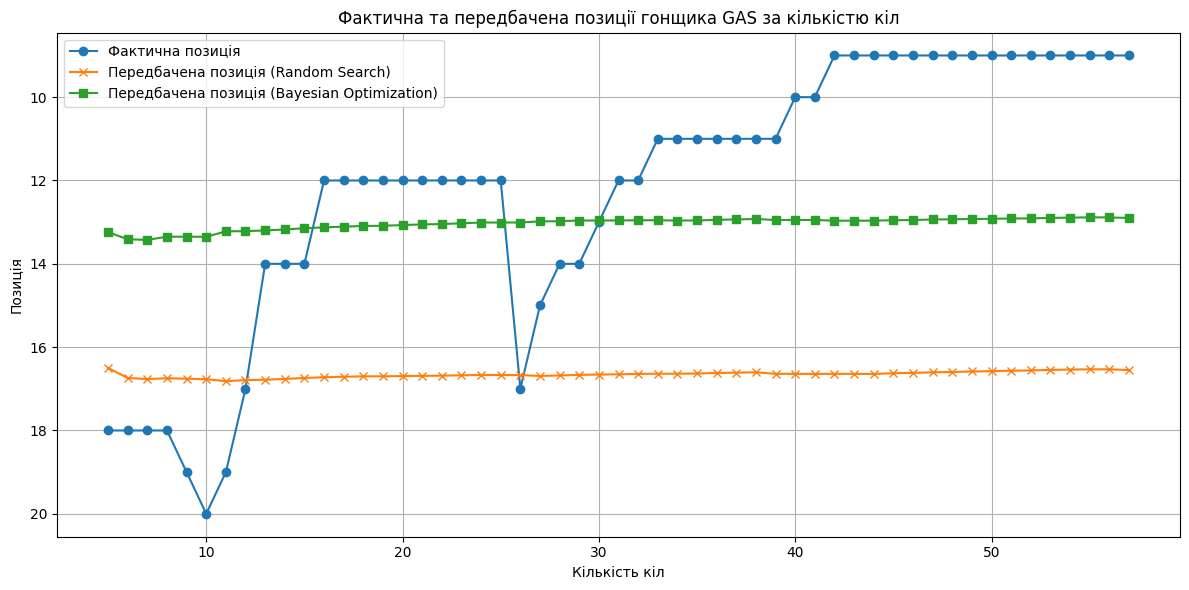

In [10]:
# Plot actual vs predicted positions over laps for each driver

drivers = all_lap_predictions['Abbreviation_Race'].unique()

for driver in drivers:
    driver_data = all_lap_predictions[all_lap_predictions['Abbreviation_Race'] == driver]
    plt.figure(figsize=(12, 6))
    plt.plot(driver_data['LapNumber'], driver_data['ActualRacePosition'], label='Фактична позиція', marker='o')
    plt.plot(driver_data['LapNumber'], driver_data['PredictedRacePosition_Model1'], label='Передбачена позиція (Random Search)', marker='x')
    plt.plot(driver_data['LapNumber'], driver_data['PredictedRacePosition_Model2'], label='Передбачена позиція (Bayesian Optimization)', marker='s')
    plt.title(f'Фактична та передбачена позиції гонщика {driver} за кількістю кіл')
    plt.xlabel('Кількість кіл')
    plt.ylabel('Позиція')
    plt.legend()
    plt.gca().invert_yaxis()  # Lower race position numbers are better
    plt.grid(True)
    plt.tight_layout()
    plt.show()
